# Explorando Técnicas de Otimização e Agendamento de Taxa de Aprendizado no Dataset MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CyclicLR

class StepByStep:
    def __init__(self, model, criterion, optimizer, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.scheduler = None  # Adicionando suporte ao scheduler
        self.model.to(self.device)
        self.losses = []
        self.metrics = []

    def set_scheduler(self, scheduler):
        """Método para adicionar um scheduler ao treinamento."""
        self.scheduler = scheduler

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader

    def train(self, epochs):
        self.model.train()
        for epoch in range(epochs):
            running_loss = 0.0
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)

                self.optimizer.zero_grad()
                y_pred = self.model(X)
                loss = self.criterion(y_pred, y)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * X.size(0)

            epoch_loss = running_loss / len(self.train_loader.dataset)
            self.losses.append(epoch_loss)

            if self.scheduler:  # Atualiza o scheduler, se definido
                self.scheduler.step()

            print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss:.4f}")

            # Avaliação no conjunto de validação
            if self.val_loader:
                val_loss, val_accuracy = self.evaluate()
                self.metrics.append((val_loss, val_accuracy))
                print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    def evaluate(self):
        self.model.eval()
        running_loss, correct = 0.0, 0
        with torch.no_grad():
            for X, y in self.val_loader:
                X, y = X.to(self.device), y.to(self.device)
                y_pred = self.model(X)
                loss = self.criterion(y_pred, y)
                running_loss += loss.item() * X.size(0)
                correct += (y_pred.argmax(dim=1) == y).sum().item()
        loss = running_loss / len(self.val_loader.dataset)
        accuracy = 100 * correct / len(self.val_loader.dataset)
        return loss, accuracy

def plot_losses(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

def plot_accuracies(metrics):
    plt.figure(figsize=(10, 6))
    # Extracting accuracies from the list of tuples
    accuracies = [acc for _, acc in metrics]
    plt.plot(accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()



## 1. Preprocessamento do Dataset MNIST

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Transformações para normalizar as imagens
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carregar datasets MNIST
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Definição do dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 53.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.94MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.19MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 2. Definição do Modelo CNN

In [3]:
# Definição do modelo CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)


## 3. Treinamento e Avaliação com SGD e Momentum

In [6]:
# Configuração do otimizador SGD + Momentum
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Critério de perda
criterion = nn.CrossEntropyLoss()

# Utilização da classe StepByStep para treinamento
sbs_sgd = StepByStep(model, criterion, optimizer_sgd, device='cpu')  # Logging a cada época
sbs_sgd.set_loaders(train_loader, test_loader)
sbs_sgd.train(10)  # Treinar por 10 épocas




Epoch 1/10 - Loss: 0.3438
Validation - Loss: 0.0549, Accuracy: 98.28%
Epoch 2/10 - Loss: 0.0516
Validation - Loss: 0.0367, Accuracy: 98.81%
Epoch 3/10 - Loss: 0.0342
Validation - Loss: 0.0316, Accuracy: 98.87%
Epoch 4/10 - Loss: 0.0263
Validation - Loss: 0.0310, Accuracy: 98.98%
Epoch 5/10 - Loss: 0.0205
Validation - Loss: 0.0275, Accuracy: 99.13%
Epoch 6/10 - Loss: 0.0168
Validation - Loss: 0.0273, Accuracy: 99.14%
Epoch 7/10 - Loss: 0.0133
Validation - Loss: 0.0332, Accuracy: 98.91%
Epoch 8/10 - Loss: 0.0102
Validation - Loss: 0.0276, Accuracy: 99.10%
Epoch 9/10 - Loss: 0.0081
Validation - Loss: 0.0263, Accuracy: 99.26%
Epoch 10/10 - Loss: 0.0067
Validation - Loss: 0.0251, Accuracy: 99.23%


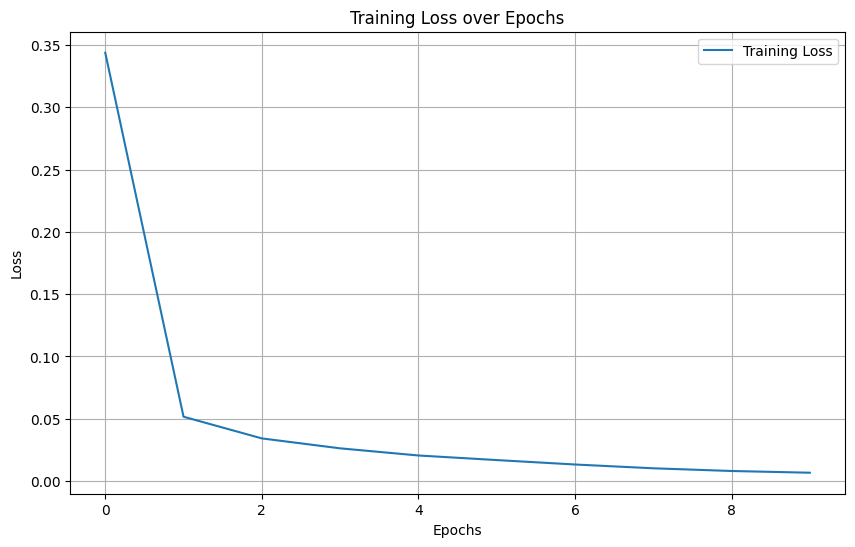

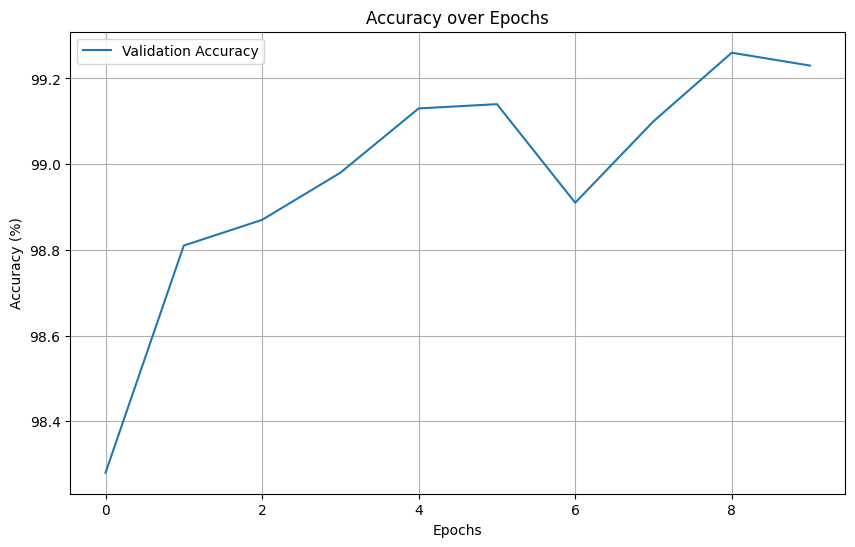

In [7]:
# Visualização de métricas de perda e acurácia
plot_losses(sbs_sgd.losses)
plot_accuracies(sbs_sgd.metrics)

## 4. Aplicação de Schedulers de Learning Rate


Epoch 1/10 - Loss: 0.2084
Validation - Loss: 0.0621, Accuracy: 98.12%
Epoch 2/10 - Loss: 0.0617
Validation - Loss: 0.0785, Accuracy: 97.57%
Epoch 3/10 - Loss: 0.0588
Validation - Loss: 0.0740, Accuracy: 97.84%
Epoch 4/10 - Loss: 0.0634
Validation - Loss: 0.1162, Accuracy: 96.70%
Epoch 5/10 - Loss: 0.0588
Validation - Loss: 0.0564, Accuracy: 98.47%
Epoch 6/10 - Loss: 0.0224
Validation - Loss: 0.0337, Accuracy: 99.00%
Epoch 7/10 - Loss: 0.0123
Validation - Loss: 0.0335, Accuracy: 98.97%
Epoch 8/10 - Loss: 0.0076
Validation - Loss: 0.0340, Accuracy: 99.10%
Epoch 9/10 - Loss: 0.0054
Validation - Loss: 0.0352, Accuracy: 99.13%
Epoch 10/10 - Loss: 0.0035
Validation - Loss: 0.0359, Accuracy: 99.17%


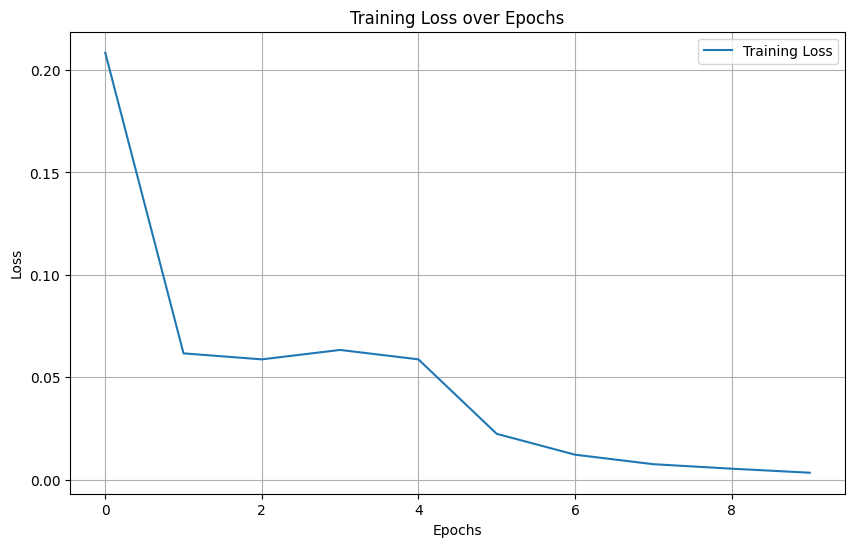

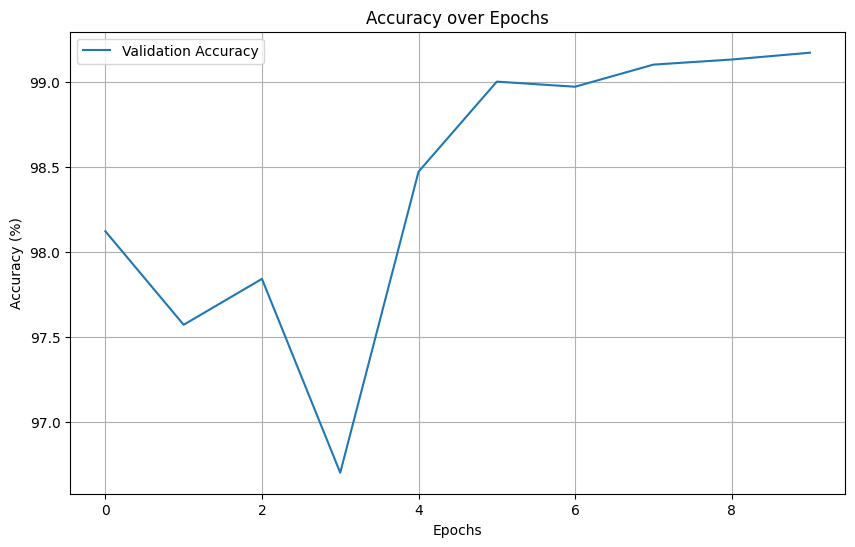

In [8]:
# Configuração do otimizador Adam
optimizer_adam = optim.Adam(model.parameters(), lr=0.01)

# Configuração do scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer_adam, step_size=5, gamma=0.1)

# Treinamento com StepByStep e scheduler
sbs_adam = StepByStep(model, criterion, optimizer_adam, device)
sbs_adam.set_scheduler(scheduler)
sbs_adam.set_loaders(train_loader, test_loader)
sbs_adam.train(10)  # Treinar por 10 épocas

# Visualização de métricas de perda e acurácia
plot_losses(sbs_adam.losses)
plot_accuracies(sbs_adam.metrics)


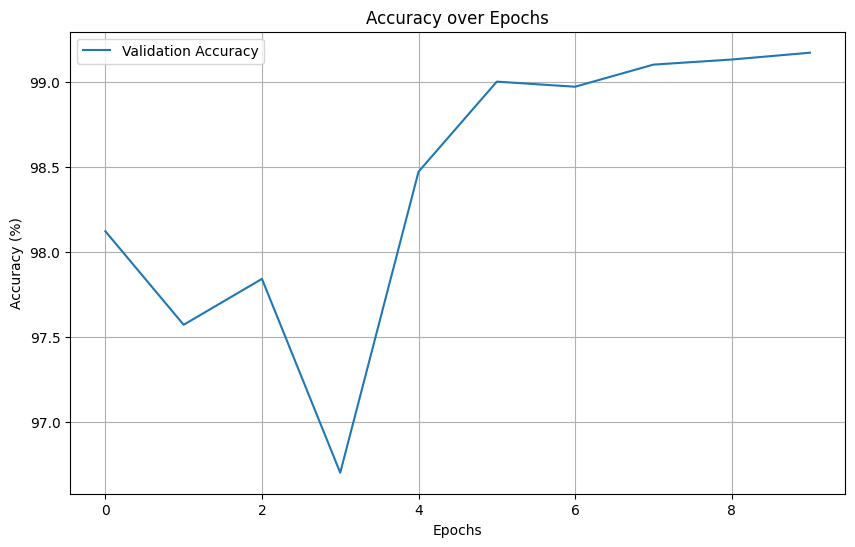

In [9]:
plot_accuracies(sbs_adam.metrics)


## 5. Visualização de Resultados

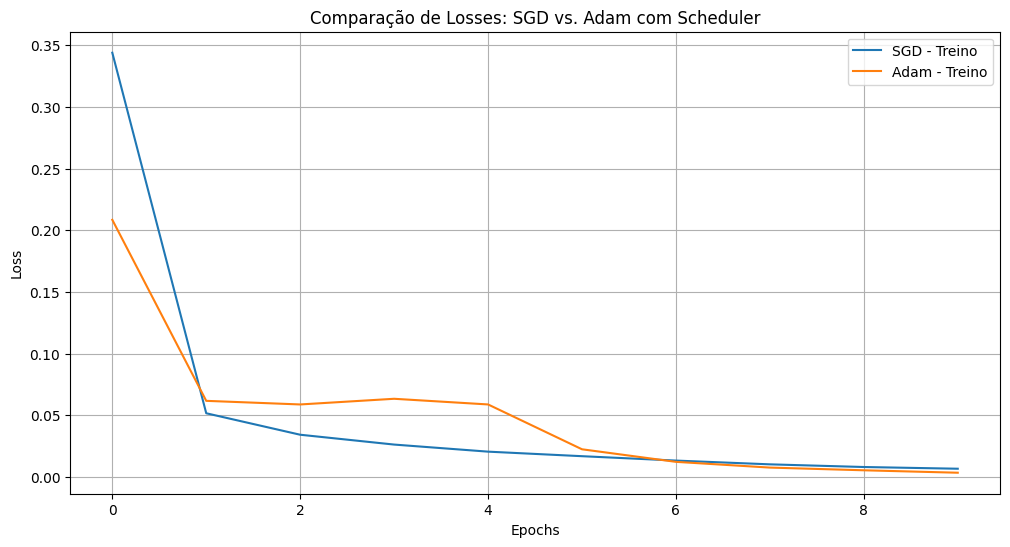

In [10]:
# Comparação entre otimizadores e schedulers
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Losses para SGD
plt.plot(sbs_sgd.losses, label='SGD - Treino')

# Losses para Adam com Scheduler
plt.plot(sbs_adam.losses, label='Adam - Treino')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparação de Losses: SGD vs. Adam com Scheduler')
plt.legend()
plt.grid()
plt.show()

## 6. Aplicação de Learning Rate Schedulers


In [11]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss


def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred, y)
            running_loss += loss.item() * X.size(0)
            correct += (y_pred.argmax(dim=1) == y).sum().item()
    loss = running_loss / len(val_loader.dataset)
    accuracy = 100 * correct / len(val_loader.dataset)
    return loss, accuracy

schedulers = {
    "Step Decay": StepLR,
    "Exponential Decay": ExponentialLR,
    "Cyclic LR": CyclicLR
}

scheduler_results = {}

# Define epochs
epochs = 10

for scheduler_name, scheduler_fn in schedulers.items():
    model = SimpleCNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    if scheduler_name == "Cyclic LR":
        scheduler = scheduler_fn(optimizer, base_lr=0.01, max_lr=0.1, step_size_up=5, mode='triangular')
    else:
        scheduler = scheduler_fn(optimizer, step_size=5, gamma=0.5) if scheduler_name == "Step Decay" else scheduler_fn(optimizer, gamma=0.9)

    train_losses, val_accuracies = [], []
    for epoch in range(epochs):
        # Call the train and evaluate functions
        train_loss = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy = evaluate(model, test_loader, criterion, device)
        scheduler.step()

        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)
        print(f"{scheduler_name} - Epoch {epoch+1}/{epochs}: Train Loss = {train_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

    scheduler_results[scheduler_name] = {"train_losses": train_losses, "val_accuracies": val_accuracies}

Step Decay - Epoch 1/10: Train Loss = 0.2880, Val Accuracy = 98.0500
Step Decay - Epoch 2/10: Train Loss = 0.0901, Val Accuracy = 98.7600
Step Decay - Epoch 3/10: Train Loss = 0.0664, Val Accuracy = 98.9500
Step Decay - Epoch 4/10: Train Loss = 0.0533, Val Accuracy = 98.8300
Step Decay - Epoch 5/10: Train Loss = 0.0472, Val Accuracy = 98.9900
Step Decay - Epoch 6/10: Train Loss = 0.0327, Val Accuracy = 99.1700
Step Decay - Epoch 7/10: Train Loss = 0.0300, Val Accuracy = 99.0900
Step Decay - Epoch 8/10: Train Loss = 0.0273, Val Accuracy = 99.2400
Step Decay - Epoch 9/10: Train Loss = 0.0251, Val Accuracy = 99.2500
Step Decay - Epoch 10/10: Train Loss = 0.0225, Val Accuracy = 99.2200
Exponential Decay - Epoch 1/10: Train Loss = 0.2916, Val Accuracy = 98.1600
Exponential Decay - Epoch 2/10: Train Loss = 0.0917, Val Accuracy = 98.7100
Exponential Decay - Epoch 3/10: Train Loss = 0.0683, Val Accuracy = 98.8700
Exponential Decay - Epoch 4/10: Train Loss = 0.0545, Val Accuracy = 98.8700
Expon

## 7. Visualizações de Resultados

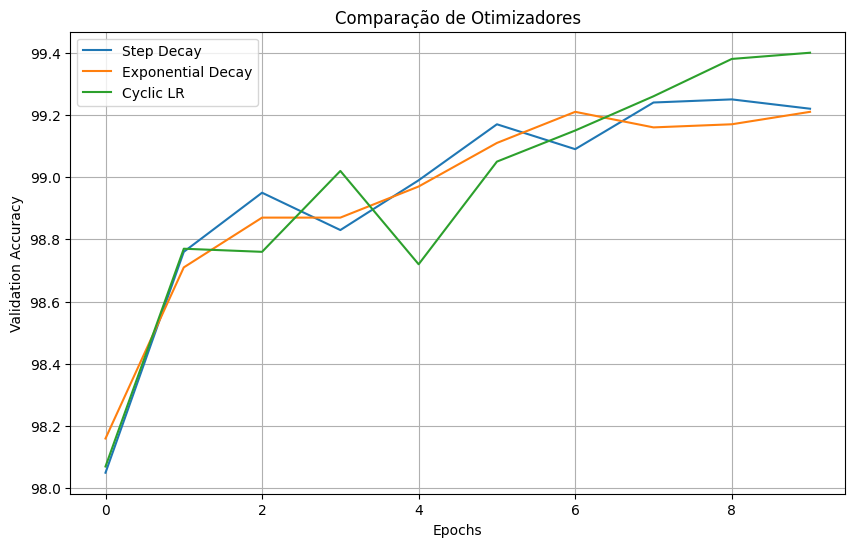

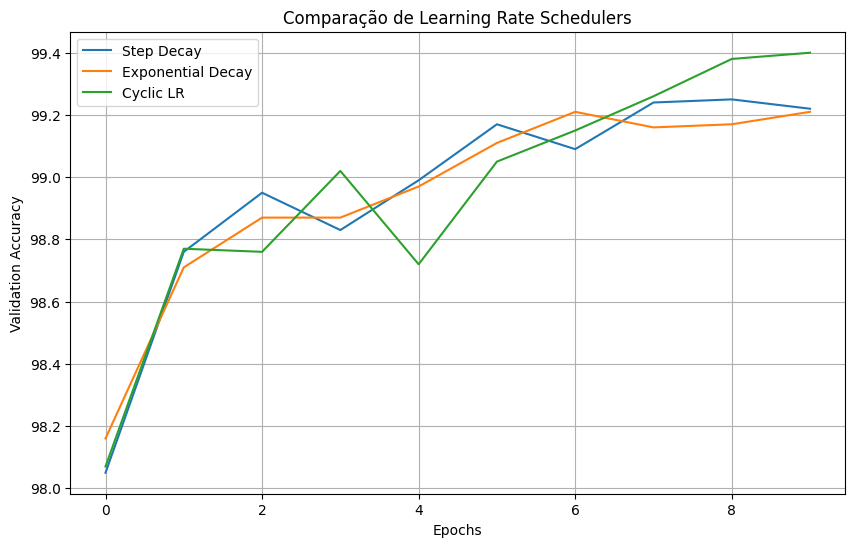

In [12]:
# Comparação: Adam vs. SGD + Momentum
plt.figure(figsize=(10, 6))
# Changed 'results' to 'scheduler_results'
for opt_name, metrics in scheduler_results.items():
    plt.plot(metrics["val_accuracies"], label=opt_name)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Comparação de Otimizadores")
plt.legend()
plt.grid()
plt.show()

# Comparação de Learning Rate Schedulers
plt.figure(figsize=(10, 6))
for scheduler_name, metrics in scheduler_results.items():
    plt.plot(metrics["val_accuracies"], label=scheduler_name)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Comparação de Learning Rate Schedulers")
plt.legend()
plt.grid()
plt.show()